# Portfolio Optimization using Markowitz Model
<hr>

## 1. Import Libraries

In [598]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
sns.set(style='whitegrid')

## 2. Asset Selection

In [600]:
# Define asset tickers
tickers = ['AAPL', 'WMT', 'NVDA', 'TM', 'JPM', 'AVGO', 'TSLA', 'ASML']
data = yf.download(tickers, start='2019-04-01', end='2022-03-31', group_by='ticker', auto_adjust=False)

# Extract adjusted close prices
adj_close = pd.DataFrame({ticker: data[ticker]['Adj Close'] for ticker in tickers})
returns = adj_close.pct_change().dropna()
returns.describe()

[*********************100%***********************]  8 of 8 completed


,AAPL,WMT,NVDA,TM,JPM,AVGO,TSLA,ASML
count,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000,756.000000
mean,0.002002,0.000731,0.002885,0.000768,0.000768,0.001399,0.004824,0.002047
std,0.021386,0.014187,0.031289,0.015023,0.022829,0.024127,0.043171,0.025526
min,-0.128647,-0.090711,-0.184521,-0.086245,-0.149649,-0.199129,-0.210628,-0.173492
25%,-0.007936,-0.005763,-0.013197,-0.006380,-0.008793,-0.009708,-0.017214,-0.010353
50%,0.001479,0.000206,0.002900,0.000730,0.000666,0.002056,0.002701,0.002007
75%,0.013442,0.006574,0.019032,0.008359,0.010613,0.013514,0.024601,0.015849
max,0.119808,0.117085,0.171564,0.095760,0.180125,0.158337,0.198949,0.116063


## 3. Portfolio Optimization

In [602]:
# Mean returns and covariance matrix
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_assets = len(tickers)

# Constraints: weights sum to 1, no short selling
def portfolio_performance(weights):
    returns = np.dot(weights, mean_returns) * 252
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix * 252, weights)))
    return returns, risk

def negative_sharpe_ratio(weights):
    p_ret, p_risk = portfolio_performance(weights)
    return -p_ret / p_risk

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

# Optimization(Using Sequential Least Squares Programming)
opt_result = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
opt_weights = opt_result.x

opt_weights

array([2.47186034e-01, 2.38119031e-01, 1.16486026e-01, 3.47515552e-02,
       1.19668815e-16, 1.25496401e-17, 3.41925870e-01, 2.15314823e-02])

### Assumptions
<li>
    <b>Weights are Fully Invested</b> <br>The portfolio weights sum to 1, meaning all capital is allocated across assets, with no cash left uninvested.
</li>
<br>
<li>
    <b>No Short Selling</b> <br>Constraints were applied, the model have disallowed short positions (weights < 0)
</li>

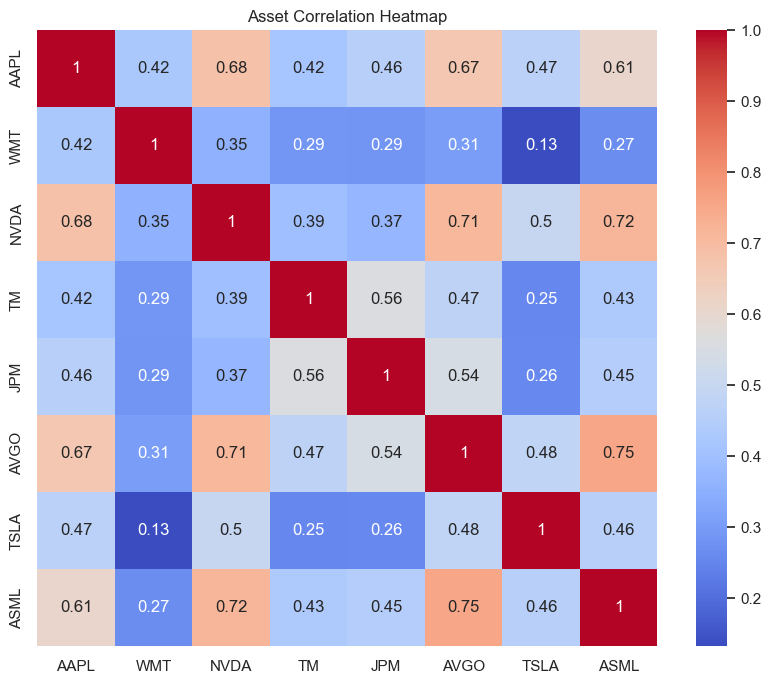

In [604]:
plt.figure(figsize=(10, 8))
sns.heatmap(returns.corr(), annot=True, cmap='coolwarm')
plt.title("Asset Correlation Heatmap")
plt.show()

In [605]:
opt_ret = np.dot(opt_weights, mean_returns)*252
opt_risk = np.sqrt(np.dot(opt_weights.T, np.dot(cov_matrix * 252, opt_weights)))
print(f"Optimal Return: {opt_ret*100: .4f}%")
print(f"Optimal Risk: {opt_risk: .4f}")

Optimal Return:  68.6783%
Optimal Risk:  0.3495


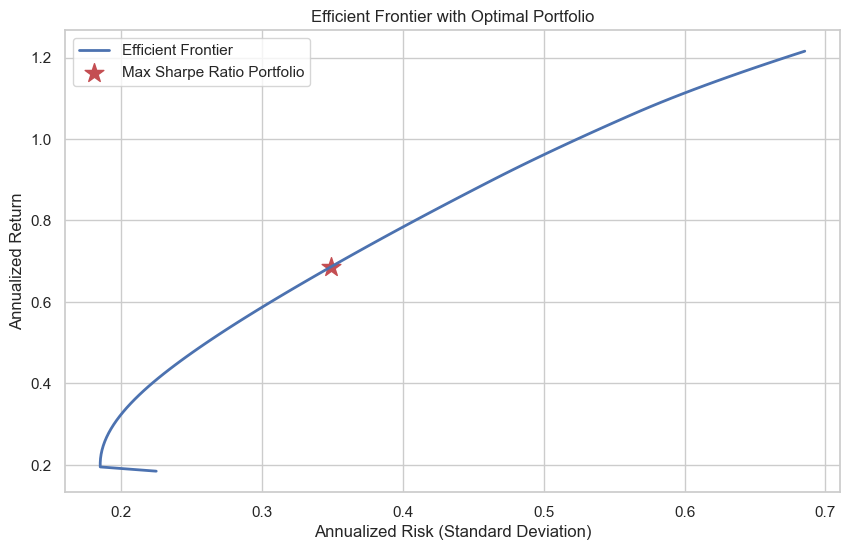

In [606]:
eff_risks = []
eff_returns = []

eff_returns = np.linspace(min(mean_returns)*252, max(mean_returns)*252, num=100)

for ret in eff_returns:
    constraints = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # sum of weights = 1
        {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns)*252 - ret}  # target return
    )
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = num_assets * [1. / num_assets]

    result = minimize(negative_sharpe_ratio, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    wts = result.x
    risk = np.sqrt(np.dot(wts.T, np.dot(cov_matrix * 252, wts)))
    eff_risks.append(risk)

plt.figure(figsize=(10, 6))
plt.plot(eff_risks, eff_returns, label='Efficient Frontier', linewidth=2)
plt.scatter(opt_risk, opt_ret, marker='*', color='r', s=200, label='Max Sharpe Ratio Portfolio')
plt.title('Efficient Frontier with Optimal Portfolio')
plt.xlabel('Annualized Risk (Standard Deviation)')
plt.ylabel('Annualized Return')
plt.legend()
plt.grid(True)
plt.show()

# 4. Backtesting (April 2022 to March 2025)

[*********************100%***********************]  8 of 8 completed


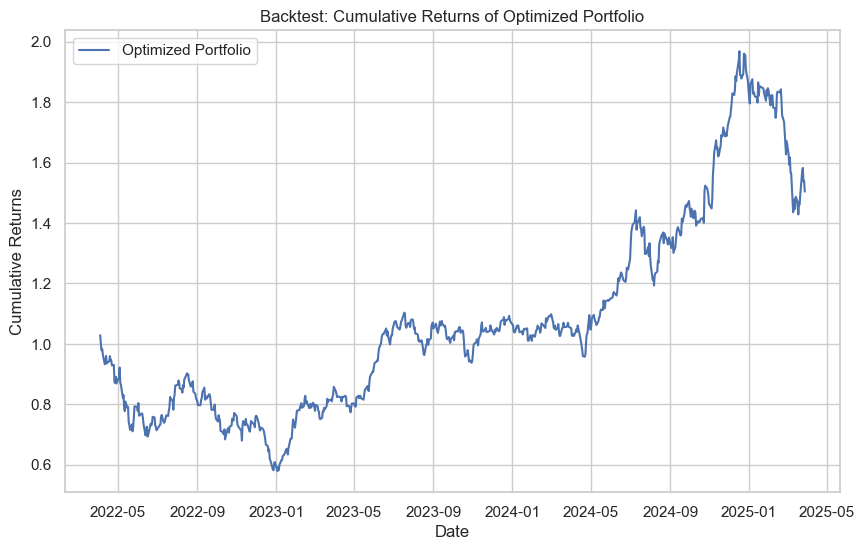

In [608]:
data = yf.download(tickers, start='2022-04-01', end='2025-03-31', group_by='ticker', auto_adjust=False)

# Extract adjusted close prices
adj_close = pd.DataFrame({ticker: data[ticker]['Adj Close'] for ticker in tickers})
returns = adj_close.pct_change().dropna()

portfolio_returns = returns.dot(opt_weights)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.title('Backtest: Cumulative Returns of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

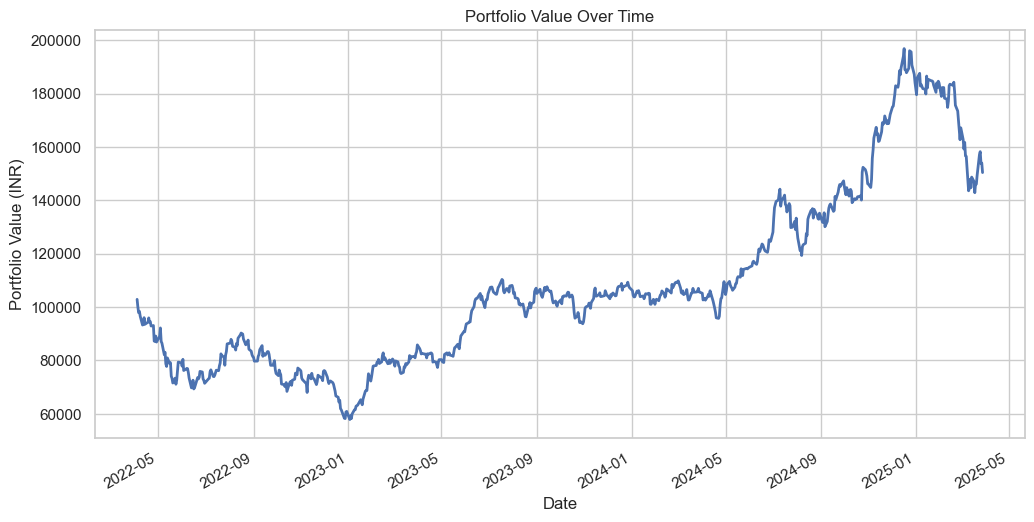

In [609]:
# Simulate portfolio value over time, starting with 100,000 INR
initial_investment = 100000
portfolio_value = (1 + portfolio_returns).cumprod() * initial_investment

# Plot portfolio value over time
plt.figure(figsize=(12, 6))
portfolio_value.plot(title='Portfolio Value Over Time', linewidth=2)
plt.ylabel('Portfolio Value (INR)')
plt.grid(True)
plt.show()

## 5. Performance Metrics

In [611]:
# Summary statistics
total_return = portfolio_value.iloc[-1] / initial_investment - 1
annualized_return = portfolio_returns.mean() * 252
annualized_volatility = portfolio_returns.std() * np.sqrt(252)
sharpe_ratio = annualized_return / annualized_volatility

print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")

Total Return: 50.40%
Annualized Return: 18.62%
Annualized Volatility: 31.26%
Sharpe Ratio: 0.60


### SUMMARY STATISTICS
<b>Total Return:</b> 50.40%
<br>
<b>Annualized Return:</b> 18.62%
<br>
<b>Annualized Volatility:</b> 31.26%
<br>
<b>Sharpe Ratio:</b> 0.60

## 6. Optimized Portfolio Weights

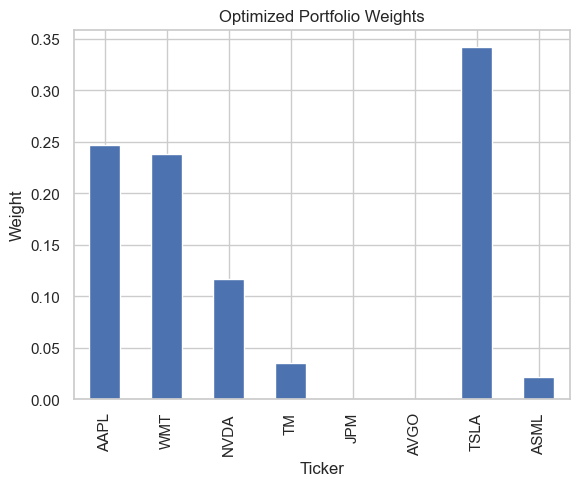

In [614]:
opt_weights_df = pd.DataFrame({'Ticker': tickers, 'Weight': opt_weights})
opt_weights_df.set_index('Ticker').plot(kind='bar', legend=False, title='Optimized Portfolio Weights')
plt.ylabel('Weight')
plt.show()

In [615]:
opt_weights

array([2.47186034e-01, 2.38119031e-01, 1.16486026e-01, 3.47515552e-02,
       1.19668815e-16, 1.25496401e-17, 3.41925870e-01, 2.15314823e-02])

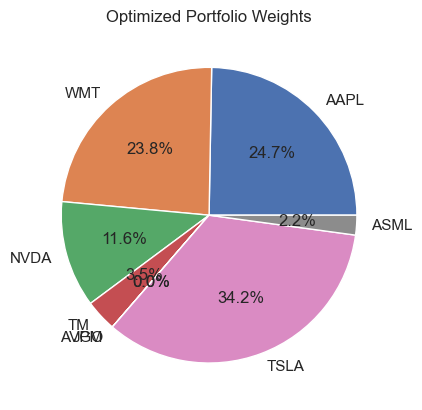

In [616]:
opt_weights_df = pd.DataFrame({'Ticker': tickers, 'Weight': opt_weights})
opt_weights_df.set_index('Ticker').plot(
    kind='pie',
    y='Weight',
    legend=False,
    title='Optimized Portfolio Weights',
    autopct='%1.1f%%',
    ylabel=''
)
plt.ylabel('')  # Optional: Removes default label
plt.show()

<center>
    <hr>
    <h3>END</h3>
    <hr>
</center>